<a href="https://colab.research.google.com/github/star6973/lotte_studying/blob/inhwa/Research/INHWA/deep_learning/image_classification/efficientNet_nomal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
#model = EfficientNet.from_name('efficientnet-b0')


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp36-none-any.whl size=16031 sha256=576d147b514e60321e96cb655e29538d43933aec5d62cf90ac8d4bb8df29ffc9
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import json
from PIL import Image


import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, RandomSampler
from torch.optim import lr_scheduler


import torchvision
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
#from torchvision import transforms

import cv2
import time
import os
import copy
import random as rand
from random import *
from efficientnet_pytorch import EfficientNet
from torchvision import transforms, datasets

model_name = 'efficientnet-b0'  # b5

image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_name(model_name, num_classes=7)

224


In [ ]:
train_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
}

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

In [ ]:
data_dir = "/content/drive/My Drive/Colab Notebooks/Labeld_Crop_Data"
trDsets = {x: dset.ImageFolder(os.path.join(data_dir, x), train_transforms[x]) for x in ['train', 'val']}
trLoaders = {x: torch.utils.data.DataLoader(trDsets[x], batch_size=128, shuffle=True) for x in ['train', 'val']}  

teDsets = dset.ImageFolder(os.path.join(data_dir,'test'), transform=test_transforms)
teLoaders = torch.utils.data.DataLoader(teDsets, batch_size=128, shuffle=False)

In [ ]:
testPath = "/content/drive/My Drive/Colab Notebooks/Resize_Crop_Data_2"
testDir = dset.ImageFolder(os.path.join(testPath, 'train'))
numList = [i for i in range(len(testDir))]

In [ ]:
def display_augmented_images(customTransform):
    fig, subplots = plt.subplots(2, 5, figsize=(13, 6))
    
    for i in range(5):
        axi1 = subplots.flat[i]
        axi2 = subplots.flat[i+5]

        ori_img = testDir[randSample[i]][0]
        trf_img = customTransform(ori_img)

        axi1.imshow(ori_img)
        axi2.imshow(transforms.functional.to_pil_image(trf_img))
        axi1.set_title('original')
        axi2.set_title('transformed')

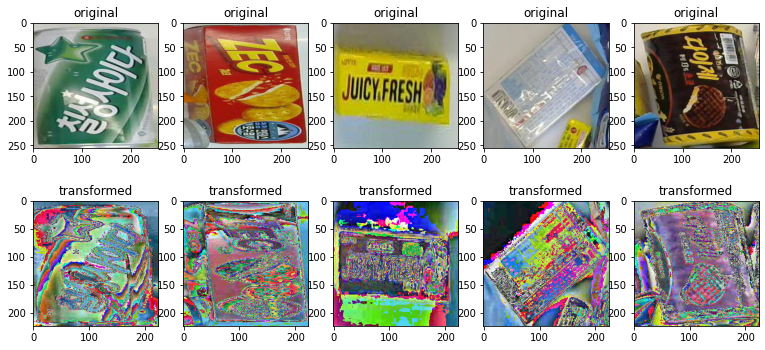

In [ ]:
randSample = rand.sample(numList, 5)
norm1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
display_augmented_images(norm1)

In [ ]:
print(trDsets['train'].classes)
print(teDsets.classes)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
trDsets_sizes = {x: len(trDsets[x]) for x in ['train', 'val']}
print(trDsets_sizes)
class_names = trDsets['train'].classes
print(class_names)

{'train': 9936, 'val': 2503}
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
print(torch.cuda.is_available())     # GPU 사용 가능 여부
print(torch.cuda.current_device())   # GPU 디바이스의 위치
print(torch.cuda.device_count())     # 사용가능한 GPU 개수
print(torch.cuda.get_device_name(0)) # GPU의 이름
print(torch.cuda.device(0))

True
0
1
Tesla K80


In [ ]:
device = torch.device("cuda:3" if torch.cuda.is_available() else 'cpu')

In [ ]:
model = EfficientNet.from_name('efficientnet-b0')
num_ftrs = model._fc.in_features
print(num_ftrs)
model.fc = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)
print(model)

1280
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_

In [ ]:

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

'''
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1, patience=5)
'''

'''
  loss="categorical_crossentropy",
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=["acc"],
    '''

    '''
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
'''

'\ncriterion = nn.CrossEntropyLoss()\noptimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)\nexp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.1, patience=5)\n'

## 데이타 체크

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=8):
    
    global_info = []
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # state_dict() = 모델 불러오기 
    best_acc = 0.0
    early_stopping = EarlyStopping(patience=11, verbose=True)  # EarlyStopping = 11번에 큰 변화가 없다면 학습을 그만한다.
    for epoch in range(num_epochs):
        local_info = []
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)                                            #train 시작

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()                                   # list에 train이면 학습 val이면 평가 
            else:
                model.eval()                              
                
               if epoch > 0:
                   scheduler.step(val_loss)
                    
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in trLoaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()                              # 가중치 변화도 = 0 >> forward 

                # forward
                # tensor는 인풋값이 디폴트는 그래디언트가 안들어가있는데 이 값을  
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)                              # torch.max(output,1)은 아웃풋이 [0.1, 0.2, 0.9]일때 (0.9[값] ,2[인덱스])가 나온다 
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()                              # backward로 최신화로 스텝으로 가자 

                running_loss += loss.item() * inputs.size(0)          # item() = tensor값을 scalar값으로 표기 * input.size(0)      
            
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / trDsets_sizes[phase]
            if phase == 'val':
                val_loss = running_loss / trDsets_sizes['val']
            epoch_acc = running_corrects.double() / trDsets_sizes[phase]

            if phase == 'train':
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)
            else:
                local_info.append(epoch_loss)
                ea = epoch_acc.cpu().numpy()
                local_info.append(ea)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
 
        lr_get = get_lr(optimizer)
        print("Current learning rate : {:.8f}".format(lr_get))
        global_info.append(local_info)
        
        if phase =='val':
            early_stopping(epoch_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='/content/drive/My Drive/Colab Notebooks/pyTorch/checkpoint.pt', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## 데이터 저장


In [ ]:

#torch.cuda.empty_cache()
model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)


torch.save(model_ft, '/content/drive/My Drive/Colab Notebooks/pyTorch/ef2_model_ft.pt')


Epoch 0/99
----------


KeyboardInterrupt: ignored

## 보기


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

teDiter = iter(teLoaders) # 배치 1개씩 부른다.
images, labels = teDiter.next()
imshow(torchvision.utils.make_grid(images)) # 여러 이미지를 모아 하나의 이미지로 만들 수 잇다. 
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [ ]:
testModel = torch.load('/content/drive/My Drive/Colab Notebooks/pyTorch/ef2_model_ft.pt', map_location=device)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda(device)), Variable(labels.float().cuda(device))
        
        outputs = testModel(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of test images: %d %%' % (100 * correct / total))


In [ ]:
tag_classes = ['ID_gum', 'buttering', 'couque_coffee', 'chocopie', 'cidar', 'couque_white', 'coke', 'diget_ori', 'diget_choco', 'gumi_gumi', 'homerunball', 'jjolbyung_noodle', 'juicyfresh', 'jjolbyung_ori', 'spearmint', 'squid_peanut', 'samdasu', 'tuna', 'toreta', 'vita500', 'welchs', 'zec']
tag_dict = dict()
for i, label in enumerate(tag_classes):
    tag_dict[i] = label

print(tag_dict)

In [ ]:
class_correct = list(0 for i in range(len(class_names)))
class_total = list(0 for i in range(len(class_names)))
with torch.no_grad():
    for data in teLoaders:
        images, labels = data
        images, labels = Variable(images.float().cuda()), Variable(labels.float().cuda())
        
        outputs = testModel(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        for i in range(c.size(0)):
            label = labels[i]
            class_correct[int(label.item())] += c[i].item()
            class_total[int(label.item())] += 1

for i in range(len(class_names)):
    print('Accuracy of %5s : %2d %%' % (tag_dict[int(class_names[i])], 100 * class_correct[i] / class_total[i]))